In [1]:
from flakylib import *
import math
import numpy as np
import numba as nb
from numba import prange
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generation of Synthetic Dataset (Overlapping Blobs on Regular Grid)

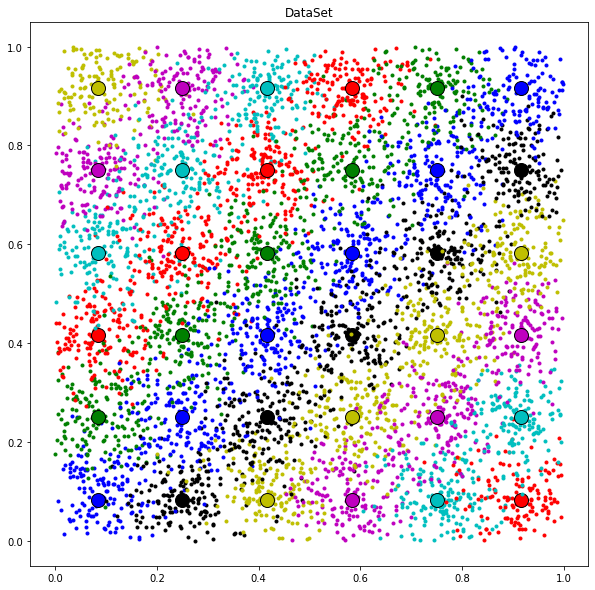

In [3]:
grid_size = 6
n_features = 2
n_samples = 6000
standard_deviation = 0.06
n_candidates = 3
distance_measure=0
#nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing

samples, true_sample_membership, true_centroids = generate_blobs_on_grid(n_samples, grid_size, n_features, standard_deviation)

if n_features == 2:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   

# Generation of Synthetic Dataset (Random Distributed Blobs)

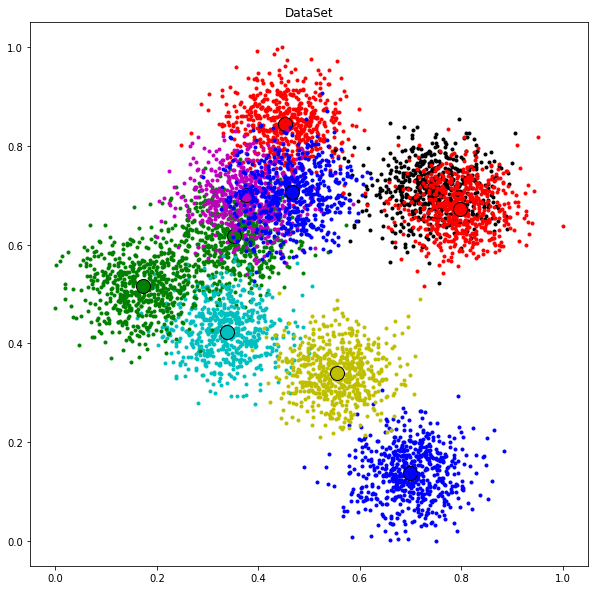

In [3]:
n_features = 2
n_samples = 6000
standard_deviation = 0.07
n_candidates = 3
distance_measure=0
#nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing
n_cluster = 10

samples, true_centroids, true_sample_membership = gaussian_blobs(n_features, n_samples, n_cluster, standard_deviation)

if n_features == 2:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   



# Generation of Synthetic Dataset (Random Distributed Samples)

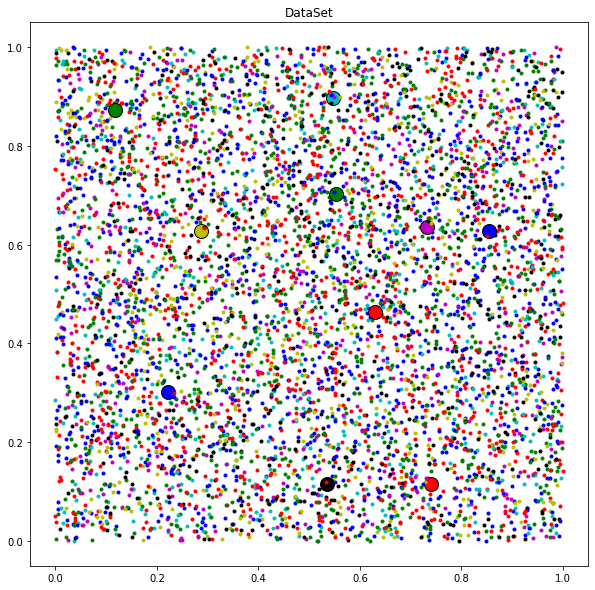

In [3]:
n_features = 2
n_samples = 6000
n_clusters = 10
n_candidates = 3
distance_measure=0
#nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing

samples = np.random.sample((n_samples,n_features))

true_sample_membership = np.random.randint(n_clusters, size = n_samples)
true_centroids = np.random.sample((n_clusters,n_features))

if n_features == 2:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
 

# Initialization by True Centroids

In [5]:
%%time

centroids = np.copy(true_centroids)

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 23.67979504363748

CPU times: user 2.9 s, sys: 8 ms, total: 2.91 s
Wall time: 2.91 s


# Initialization by Random Centroids

In [6]:
%%time

centroids = np.random.rand(n_clusters, n_features)

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')


Objective 55.76247031285635

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.08 ms


# Initialization by K-Means++

In [7]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates, distance_measure)]
centroids_copy = np.copy(centroids)

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 33.06136526394704

CPU times: user 6.9 s, sys: 36 ms, total: 6.94 s
Wall time: 6.9 s


# K-Means initialized by True Centroids

In [8]:
%%time

centroids = np.copy(true_centroids)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.123836858959006
Iterations: 22
Clusters: 36

CPU times: user 9.86 s, sys: 16 ms, total: 9.88 s
Wall time: 9.84 s


# K-Means initialized by K-Means++ with sample_objectives as weights

In [9]:
new_sample_weights = 1-normalization(sample_objectives)
center_inds = k_means_pp(samples, new_sample_weights, n_clusters, n_candidates, distance_measure)
centroids = samples[center_inds]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.224050003707088
Iterations: 38
Clusters: 36



# K-Means initialized by Random Centroids

In [10]:
%%time

centroids = np.random.rand(n_clusters, n_features)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.623018490762572
Iterations: 32
Clusters: 36

CPU times: user 108 ms, sys: 28 ms, total: 136 ms
Wall time: 42.9 ms


# K-Means initialized by K-Means++

In [11]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates, distance_measure)]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.276340242882473
Iterations: 51
Clusters: 36

CPU times: user 264 ms, sys: 124 ms, total: 388 ms
Wall time: 116 ms


# K-Means initialized by K-Means++ (sklearn)

In [12]:
%%time

# MiniBatchKMeans(KMeans) in SKLEARN ????!!!!

km = KMeans(n_clusters=n_clusters, init = 'k-means++', algorithm = 'full', n_init=1, n_jobs=1)
#km = KMeans(n_clusters=n_clusters, init = 'random', n_init=1, n_jobs=1)
km = km.fit(samples)

print('Objective:', -km.score(samples))
print('Iterations:',km.n_iter_)

Objective: 23.62829558810551
Iterations: 33
CPU times: user 928 ms, sys: 40 ms, total: 968 ms
Wall time: 240 ms


# H-Means (first-improvement strategy) initialized by True Centroids

In [13]:
%%time

centroids = np.copy(true_centroids)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.120878205166317
Iterations: 10
Clusters: 36

CPU times: user 7.61 s, sys: 0 ns, total: 7.61 s
Wall time: 7.61 s


# H-Means (first-improvement strategy) initialized by K-Means++

In [14]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.883003914989313
Iterations: 30
Clusters: 36

CPU times: user 188 ms, sys: 4 ms, total: 192 ms
Wall time: 186 ms


# H-Means initialized by Random Membership Distribution

In [15]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

random_membership(n_samples, n_clusters, sample_membership)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.073666763056284
Iterations: 25
Clusters: 36

CPU times: user 328 ms, sys: 0 ns, total: 328 ms
Wall time: 326 ms


# K-H-Means initialized by True Centroids

In [16]:
%%time

centroids = np.copy(true_centroids)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001

objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.116284105203643
Iterations: 28
Clusters: 36

CPU times: user 4.28 s, sys: 20 ms, total: 4.3 s
Wall time: 4.25 s


# K-H-Means initialized by K-Means++

In [17]:
%%time

centroids = np.copy(centroids_copy)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001


objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.88935803838663
Iterations: 71
Clusters: 36

CPU times: user 188 ms, sys: 36 ms, total: 224 ms
Wall time: 88.7 ms


# Simple Membership Shaking VNS

In [18]:
%%time

max_cpu_time = 10 # seconds
max_iters = 3000 # maximun number of iterations inside VNS

kmax = 3
h_max_iters = 300
k_max_iters = 300
h_tol = 0.05
k_tol = 0.0001


#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates, distance_measure)]
objective, n_local_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

#Glogal search

objective, n_iters = Membership_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, h_max_iters, k_tol, h_tol, kmax, max_cpu_time, max_iters, True)

print('')
print('Final objective:', objective)
print('Total number of iterations:', n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.7713690808403
Iterations: 36
Clusters: 36

23.44805256067552 1
23.444129253556177 1
23.443637026515642 1
23.443527876767835 1
23.44352787676783 2
23.443431679005197 3
23.443268073503937 1
23.44257979110805 1
23.441722903871444 1
23.441275938331085 1
23.44074898200518 2
23.43672465166192 1
23.435678390748393 1
23.434100049856585 1
23.433284151945756 1
23.432747635424118 1
23.432501691058512 1
23.43243632527113 1
23.432398011234195 3
23.432355165399418 1
23.432355165399414 1
23.432249658184574 3
23.43224965818457 1
23.43222773568132 2
23.432227735681312 1
23.43216687870355 2
23.432048183347522 1
23.431945495376077 1
23.43192658207648 1
23.431926582076475 1
23.431695710673793 3
23.43161774516691 1
23.431399203346306 2
23.43126958559268 2
23.430998139302567 1
23.430890673962107 1
23.430836333807985 1
23.43081133743918 1
23.430811337439177 2
23.43081133743917 3
23.430793423267897 3
23.430698314411238 2
23.43069831441123 3
23.42997155906603 2
23.42953877186619 1
23.429165524408

# Solution Visualization

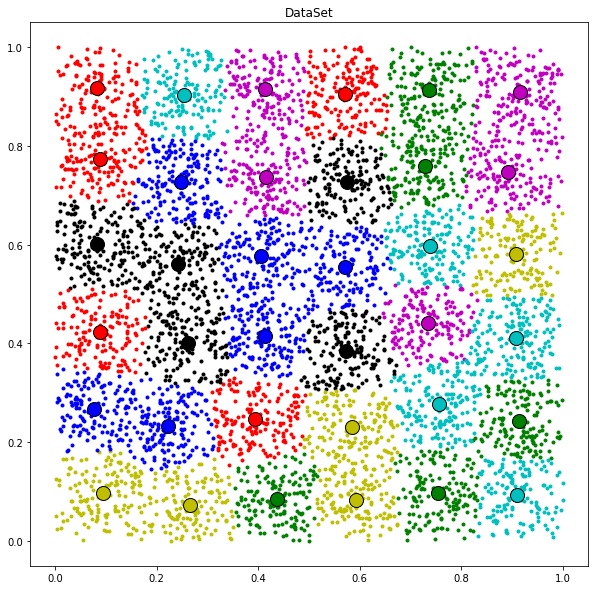

In [42]:
draw_dataset(samples, centroids, sample_membership)

# Local Search by Iteratively New Extra Center Insertion, Searching and Worst Centroid Deletion

In [32]:
%%time

# k_max_iters = 50
# k_tol=0.01
k_max_iters = 300
k_tol=0.0001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates, distance_measure)]
objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, k_tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Search

objective, n_iters, n_k_iters = iterative_extra_center_insertion_deletion(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, k_tol, max_iters, tol, max_cpu_time, n_candidates, True)
                                
print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_k_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.444473011236873
Iterations: 41
Clusters: 36

23.388127311259364
23.209781606418012
23.203082148173387
23.08570711463067
23.07485470448205
23.07178189754862
23.07178189754862

Objective: 23.07178189754862
Global Iterations: 573
Local Iterations: 23
Clusters: 36

CPU times: user 1min 3s, sys: 5.56 s, total: 1min 8s
Wall time: 10 s


# Solution Visualization

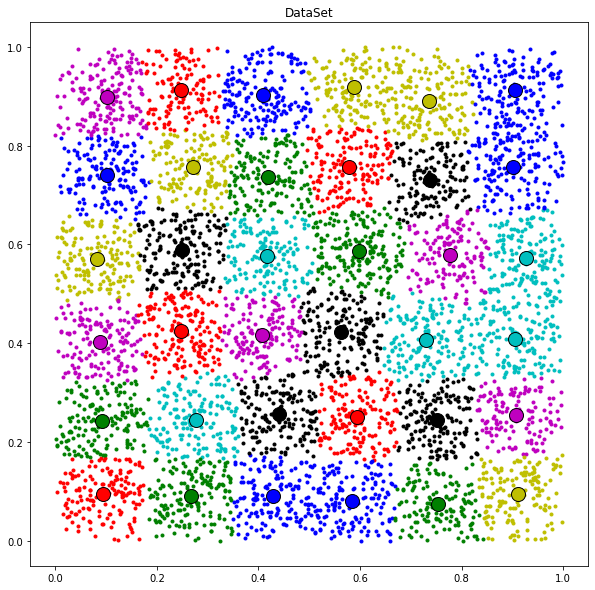

In [28]:
draw_dataset(samples, centroids, sample_membership)

# Center Shaking VNS

In [36]:
%%time

kmax = 5

local_max_iters = 300
local_tol=0.0001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates, distance_measure)]
objective, n_local_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, local_max_iters, local_tol, True)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Global Search

objective, n_iters, n_local_iters = Center_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, local_max_iters, local_tol, kmax, max_cpu_time, max_iters, n_candidates, True)

print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.819168841603194
Iterations: 28
Clusters: 36

23.63305219193821 2
23.555540871148303 2
23.458963273788857 1
23.456736378880578 5
23.12274963162139 1
23.113758738809825 2
23.096880308367215 1
23.095179062840426 1
23.093045239284038 4
23.08628961002135 3
23.086075108265845 2
23.08575719205112 2
23.07838692171353 1
23.077256021663228 1
23.077049788377362 1
23.075276290791017 1
23.070847465187956 1
23.070428554607556 1
23.069352073380713 1
23.069352073380713

Objective: 23.069352073380713
Global Iterations: 727
Local Iterations: 6
Clusters: 36

CPU times: user 1min, sys: 6.08 s, total: 1min 6s
Wall time: 10.1 s


# Solution Visualization

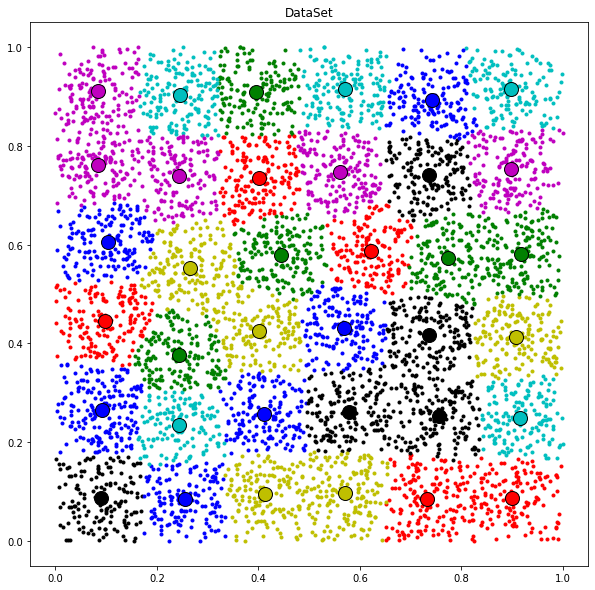

In [37]:
draw_dataset(samples, centroids, sample_membership)

# Sequencing of Different Methods

In [38]:
%%time

printing=True
local_max_iters=300
local_tol=0.0001
n_candidates=3
kmax = 5
max_iters = 3000
max_cpu_time = 3 # seconds


method_sequence = np.array([0, 4, 5, 4, 5, 3])
time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
max_iters_sequence = np.full(method_sequence.shape[0],max_iters)
#kmax_sequence = np.full(method_sequence.shape[0],kmax)
kmax_sequence = np.array([5,5,5,5,15,5])

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates, distance_measure)]

objective = method_sequencing(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, np.inf, method_sequence, time_sequence, max_iters_sequence, kmax_sequence, local_max_iters, local_tol, n_candidates, printing)

K-means:
23.81503609802165

Center Shaking VNS:
23.593363580138135 5
23.50885894753422 2
23.499495173770434 1
23.386385479189848 1
23.203100635078542 1
23.09114665207394 1
23.08953667032801 2
23.088146771918883 4
23.085000046280157 2
23.076355370165587 2
23.076355370165587

Membership Shaking VNS:
23.07552532081231 1
23.07366384380849 1
23.0716042910275 1
23.069222191355642 1
23.068587439421105 1
23.068321923150453 1
23.067442071338736 2
23.066589737784366 1
23.065925675607716 1
23.065749668402713 1
23.06574966840271 5
23.065749668402706 1
23.065712358510346 5
23.065712358510343 5
23.065660597378084 2
23.065660597378077 4
23.06554560261598 3
23.065545602615977 2
23.0655208031736 2
23.065520803173598 3
23.06552080317359 1
23.06552080317359

Center Shaking VNS:
23.06552080317359

Membership Shaking VNS:
23.06552080317359

K-H-means:
23.065520803173598

CPU times: user 1min 14s, sys: 4.24 s, total: 1min 18s
Wall time: 37.3 s


# Solution Visualization

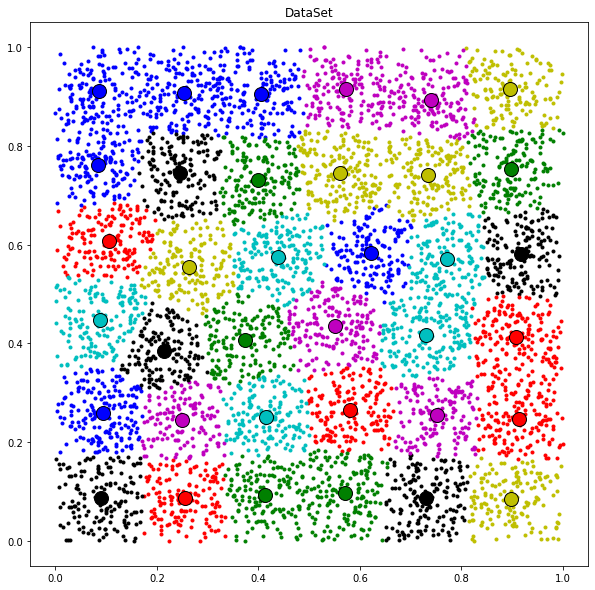

In [39]:
draw_dataset(samples, centroids, sample_membership)

# VNS based Decomposition/Aggregation Minimum Sum-Of-Squares Clustering

In [41]:
%%time

portion_size = 1000
n_portions = 5
init_method = 1
local_max_iters = 300
local_tol = 0.0001
max_cpu_time = 3
max_iters = 3000000
n_candidates = 6
aggregation_method = 1
basis_n_init = 3


# method_sequence = np.array([0, 4, 5, 4, 5, 3])
# kmax_sequence = np.array([0,5,5,5,15,0])
# time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
# max_iters_sequence = np.full(method_sequence.shape[0],max_iters)

method_sequence = np.array([4])
kmax_sequence = np.array([5])
time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
max_iters_sequence = np.full(method_sequence.shape[0],max_iters)


objective, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = decomposition_aggregation_mssc(samples, sample_weights, method_sequence, time_sequence, max_iters_sequence, kmax_sequence, n_clusters, portion_size, n_portions, init_method, local_max_iters, local_tol, n_candidates, aggregation_method, basis_n_init)



CPU times: user 59.6 s, sys: 5.06 s, total: 1min 4s
Wall time: 9.05 s


In [42]:
objective

23.070901326247743